In [82]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

## Homework #6

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name:  Kaitlyn Huynh
NetID:  kh3599
Group Members:   
***

In [83]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import pymc as pm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [84]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Question 1**. **(15 points)** In 2014, a paper was published that was entitled “Female hurricanes are deadlier than male hurricanes.” As the title suggests, the paper claimed that hurricanes with female names have caused greater loss of life, and the explanation given is that people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate. Statisticians severely criticized the paper after publication.

Here, you’ll explore the complete data used in the paper and consider the hypothesis that hurricanes with female names are deadlier.

Load the data as follows:

`df = pd.read_csv("Data/hurricanes.csv")`


The columns have the following meaning:
```
*Description*
Data used in Jung et al 2014 analysis of effect of gender of name on hurricane fatalities. Note that hurricanes Katrina (2005) and Audrey (1957) were removed from the data.

name : Given name of hurricane

year : Year of hurricane

deaths : Number of deaths

category : Severity code for storm

min_pressure : Minimum pressure, a measure of storm strength; low is stronger

damage_norm : Normalized estimate of damage in dollars

female : Indicator variable for name categorized as "female"

femininity : 1-11 scale from totally masculine (1) to totally feminine (11) for name. Average of 9 scores from 9 raters.

*Reference* 
Jung et al. 2014. Female hurricanes are deadlier than male hurricanes. PNAS.
```

To begin, you will focus on constructing Poisson Generalized Linear Models to investigate the relationship between name femininity and hurricane deaths. In pursuing this goal, you will fit two different statistical models. One will be an intercept-only model of the expected number of deaths from a hurricane using an intercept term with no predictors in the model. The second will include an intercept and a storm's femininity score as a predictor to define the expected number of deaths.

**Begin by justifying the priors used in your models for this problem using a prior predictive simulation.** 

1. Perform a brief web search on the expected number deaths due to hurricanes to help choose reasonable priors for your model. 
1. Include a brief statement (**limited to no more than 3-4 sentences**) on the information obtained and the source(s) used based on your web search.
1. **Perform two seperate prior predictive simulations**: one for the intercept-only model and one for the model that includes femininity score as a predictor.
    * For an intercept-only model, a good way to analyze the prior for the intercept parameter is to visualize the distribution of prior samples using a histogram or kde plot.
    * For the model that includes femininity as a predictor, you prior predictive simulation will include a plot of femininity vs expected number of deaths that shows how the expected number of deaths change as the (standardized) femininity score changes.
    * Refer to the Poisson GLM lecture (slides titled "Poisson Priors") for examples of prior predictive simulations for both types of models.

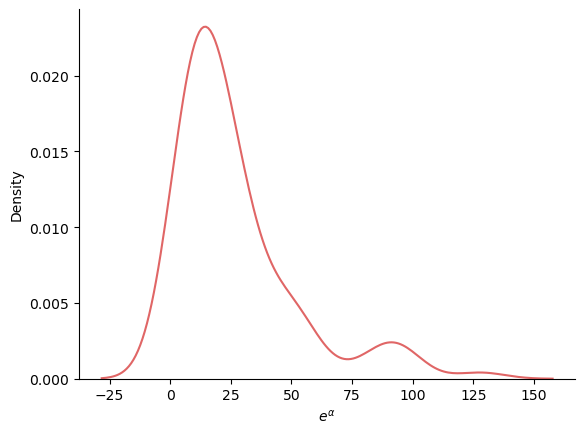

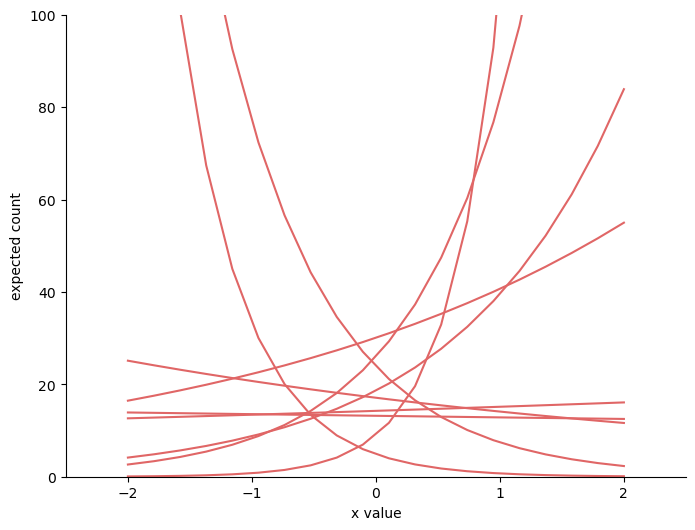

In [85]:

x_seq = np.linspace(-2, 2, 20)

# intercept only
alphas = stats.norm.rvs(3, 1, size = 100)
lambdas = np.exp(alphas)

sns.kdeplot(lambdas, color="#e06666")
plt.xlabel(r"$e^{\alpha}$")
sns.despine();

# model that includes femininity as a predictor
plt.figure(figsize=(8, 6))
NUM_LINES = 10
x_seq = np.linspace(-2, 2, 20)

alpha = stats.norm.rvs(3,1,size=NUM_LINES)
beta = stats.norm.rvs(0,1,size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * x_seq)
    _ = plt.plot(x_seq, lambdas, color="#e06666")
plt.xlim(-2.5, 2.5)
plt.ylim((0,100))
plt.ylabel("expected count")
plt.xlabel("x value")
sns.despine();


The average number of deaths per hurricane, regardless of gender, is ~24 according to this article: https://www.npr.org/2024/10/02/nx-s1-5131305/hurricanes-contribute-to-thousands-of-deaths-each-year-in-the-u-s-many-times-the-reported-number . This only takes into account direct deaths as a result of hurricanes. Deaths that occur as an aftermath of the hurricane are excluded from this average value.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Approximate the posterior of a Poisson model of hurricane deaths using *femininity* (**after standardization**) as a predictor. This **model will include two parameters**: an **intercept** and a **coefficient** that measures the effect of femininity on the expected number of deaths.

In [86]:
df = pd.read_csv("Data/hurricanes.csv")
# Initialize Poisson Priors

# df["deaths"] = standardize(np.log(df.deaths)).values # Should we standardize death?
df["deaths"] = df.deaths.values
df["female"] = standardize(np.where(df.female == 1, 1, 0))

# intercept and coefficient
with pm.Model() as poisson_femininity:
    a = pm.Normal("a", 3, 1)  # Average deaths per hurricane
    b = pm.Normal("b", 0, 1)   # Coefficient of femininity score
    mu = pm.math.exp(a + b * df.female)
    deaths = pm.Poisson("deaths", mu, observed=df.deaths)
    idata_poisson_femininity = pm.sample(
        tune=3000, 
        random_seed=145,
        idata_kwargs={"log_likelihood": True}
    )



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Approximate the posterior of a Poisson model of hurricane deaths defining the expected number of deaths using just an intercept term. This model will include only one parameter to estimate.

In [87]:
# intercept only
with pm.Model() as poisson_intercept:
    a = pm.Normal("a", 3, 1) # Log(Average deaths) per hurricane
    deaths = pm.Poisson("deaths", pm.math.exp(a), observed=df.deaths)
    idata_poisson_intercept = pm.sample(
                    tune=3000, 
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Based on the model estimates, how strong is the association between femininity of storm name and deaths? **Limit your response to no more than 3 sentences.**

*Hint: The response to this question should be based on parameter estimate(s) from your model.* **Be sure to reference the estimated association (using a quantitative anaysis or visual analysis of a plot) in your answer.**

In [88]:
# az.compare({"poisson_femininity": idata_poisson_femininity, "poisson_intercept": idata_poisson_intercept}, scale="deviance")
fem_summary = az.summary(idata_poisson_femininity, kind="stats")
int_summary = az.summary(idata_poisson_intercept, kind="stats")
print(fem_summary)
print("=" * 50)
print(int_summary)

    mean     sd  hdi_5.5%  hdi_94.5%
a  3.001  0.023     2.962      3.035
b  0.241  0.026     0.199      0.279
    mean     sd  hdi_5.5%  hdi_94.5%
a  3.027  0.023     2.989       3.06


The association between femininity of storm name and deaths is slightly positive at a value of 0.241 but on the weaker side. Since this association is quite low, it isn't a strong factor in determining if female names are associated with more deaths due to hurricanes. The mean in both models are similar at a value of ~3.0. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(15 points)** In this problem, you’ll focus on predicting deaths using the femininity score of each hurricane’s name. 

Perform posterior predictive checks to evaluate how well the femininity score model predicts the observed data. This posterior predictive check will include a plot with the following components: 

* name femininity (standardized) on the x-axis
* number of deaths on the y-axis
* observed death counts from the dataset as scatter plot points
* posterior mean showing the average relationship between femininity and number of deaths
* uncertainty of posterior mean
* uncertainty of posterior predictions (requires making predictions using samples from your posterior) 

An example of this approach to performing posterior predictive checks can be found in the *Linear Regression* lecture in the section titled "Posterior Predictive Checks". You will want to generalize the approach from that lecture so that it applies to a Poisson regression model. Feel free to use the function `pymc.sample_posterior_predictive()` to reduce the amount of code that you write. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [deaths]


/tmp/ipykernel_341/1783599109.py:27: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hpd = az.hdi(posterior_mu, hdi_prob=0.94)


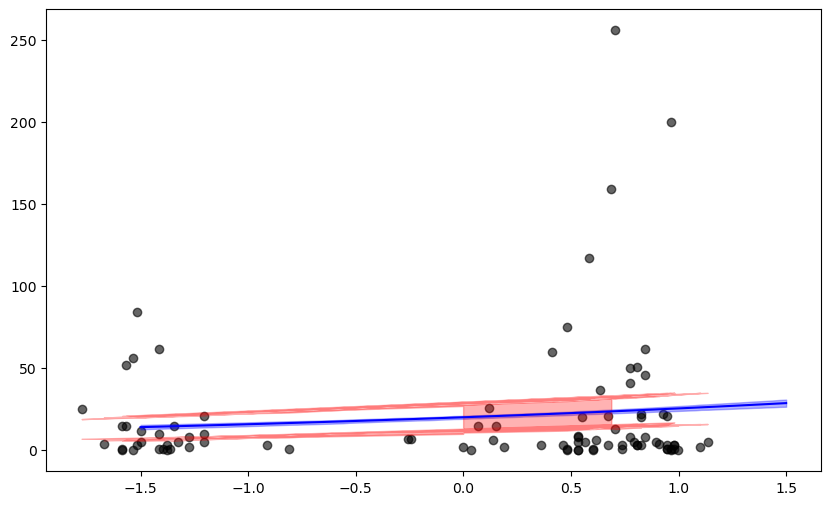

In [89]:
df["femininity_scores"] = standardize(df["femininity"])
femininity_scores = df["femininity_scores"].values
death_count = df["deaths"].values

with pm.Model() as model:
    a = pm.Normal("a", mu=3, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    mu = pm.math.exp(a + b * femininity_scores)  # Poisson regression
    deaths = pm.Poisson("deaths", mu=mu, observed=death_count)
    
    samples = pm.sample()

    # take samples from posterior predictive values
    ppc = pm.sample_posterior_predictive(samples, var_names=["deaths"])

# create the grid
grid = np.linspace(-1.5, 1.5, 100)

# base mu on model predictions
a_samples = samples.posterior["a"].values.flatten()
b_samples = samples.posterior["b"].values.flatten()
posterior_mu = np.exp(a_samples[:, None] + b_samples[:, None] * grid[None, :]) # calculate expected # of deaths per hurricane across each sampled value


# calculate mean and 94% hpdi
mu_mean = posterior_mu.mean(axis=0)
mu_hpd = az.hdi(posterior_mu, hdi_prob=0.94)

# calculate check from mean
check = ppc.posterior_predictive["deaths"].values

mean = check.mean(axis=0)
hpdi = az.hdi(check, hdi_prob=0.94)


plt.figure(figsize=(10, 6))

# plot the observed data
plt.scatter(femininity_scores, death_count, color="black", alpha=0.6, label="Observed deaths")

# add the curve of mu onto grid
plt.plot(grid, mu_mean, color="blue", label="Posterior mean")

# visualize uncertainty window  94%
plt.fill_between(grid, mu_hpd[:, 0], mu_hpd[:, 1], color="blue", alpha=0.3, label="94% HDI (mean)")

# Uncertainty in predictions (red)
plt.fill_between(femininity_scores, hpdi[:, 0], hpdi[:, 1], color="red", alpha=0.3, label="94% HDI (predictions)")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Based on your plot, how effective is the femininity score model at predicting storm deaths? **Limit your response to no more than 3 sentences**

The femininity score model is not very effective since there are many observations falling outside of the highlighted interval. The range of uncertainty from 0.0 to ~0.7 is also quite wide which means the analysis of each observation could be uncertain. There are many outliers that do not fall within the model's prediction range.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Compare the predictive ability** of the hurricane name femininity model to the intercept-only model. **State which model is better for prediction** based on the predictive criteria tools (PSIS or WAIC) covered earlier in the semester.

In [90]:
az.compare({"poisson_femininity": idata_poisson_femininity, "poisson_intercept": idata_poisson_intercept}, scale="deviance")

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
poisson_femininity,0,4372.827012,106.914335,0.000000,0.431439,985.305587,0.000000,True,deviance
poisson_intercept,1,4425.254220,70.007072,52.427208,0.568561,1061.795593,137.530239,True,deviance


The model that includes the intercept and coefficient for femininity is better for prediction. It has a lower rank (0) which indicates it is better at predicting incoming observations than the intercept-only model. Additionally, the rank 0 model has a lower elpd_diff value which indicates a better performance at predicting deaths due to hurricanes.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Which storms does the model including femininity as a predictor fit poorly? **Limit your response to no more than 4 sentences.** 

Hints for this question:  

* Reviewing the prediction tutorial and the *Prediction* lecture from earlier in the semester will be beneficial for answering this question and the next. 
* You will want to quantify the influence that each data point has on the model's posterior. Data points that are fit poorly by the model will have more influence on the posterior distribution.
* You'll want to examine the relationship between storm femininity scores and the influence of the data points which the model does not fit well. 

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


       name  year  deaths  category  min_pressure  damage_norm    female  \
28  Camille  1969     256         5           909        23040  0.695608   
9     Diane  1955     200         1           987        14730  0.695608   
88      Ike  2008      84         2           950        20370 -1.437591   
91    Sandy  2012     159         2           942        75000  0.695608   
58   Andrew  1992      62         5           922        66730 -1.437591   
..      ...   ...     ...       ...           ...          ...       ...   
42   Alicia  1983      21         3           962        10400  0.695608   
7     Hazel  1954      20         4           938        24260  0.695608   
6      Edna  1954      20         3           954         3230  0.695608   
21    Hilda  1964      37         3           950         2770  0.695608   
63     Fran  1996      26         3           954         8260  0.695608   

    femininity  femininity_scores  pareto_k  
28     9.05556           0.704867  2.1015

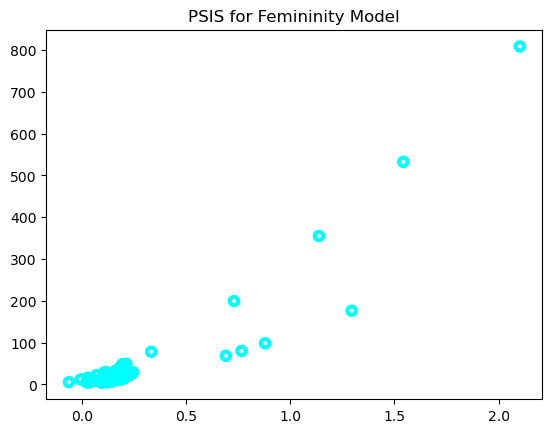

In [91]:
# psis and waic test
psis_femininity = az.loo(idata_poisson_femininity, pointwise=True)
waic_femininity = az.waic(idata_poisson_femininity, pointwise=True, scale="deviance")
df["pareto_k"] = psis_femininity.pareto_k
poor_storms = df.sort_values("pareto_k", ascending=False)
print(poor_storms)
# Plot k-hat values to visualize influential points
plt.scatter(psis_femininity.pareto_k, waic_femininity.waic_i, facecolors='none', edgecolors="cyan", lw=3)
plt.title("PSIS for Femininity Model")
plt.show()


Models with high death counts that strongly deviate from the typical observed deaths per hurricane are poorly predicted. Hurricanes that have both low and high scores of femininity are scoring a fluctuating number of deaths, it could be high or low. These storms might benefit from including more factors to better the prediction model. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

In light of the analysis performed in this question and the previous one, what do you make of the claim that female hurricanes are deadlier than male hurricanes because people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate? 

* Consider both the causal and predictive analyses performed on the dataset. 
* Be sure to support your response based on the analysis you have performed.

**Limit your response to no more than 5 sentences.**

The claim that female hurricanes are deadlier than male hurricanes seems to be weak according to the data. There is evidence where including femininity scores in an attempt to better predict hurricane deaths showing weak associations. Additionally, the model has a potential flaw where it inaccurately predicts deaths of some storms, regardless of their femininity scores. For example, some storms that have higher death tolls are feminine, and others aren't. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(20 points)** In the trolley data — `Data/Trolley.csv` — we saw how education level (modeled as an ordered category) is associated with responses. But is this association causal? One plausible confound is that education is also associated with age through a causal process: People are older when they finish school than when they begin it.

Reconsider the trolley data in this light. 

Include a DAG (reference the DAG tutorial included with Homework 5 for instructions creating a DAG in Python) that represents causal relationships amongst response, education, and age **based on the associations described above**. For the purposes of this problem, you can ignore any other variables from the dataset in this DAG. **Clearly identify what each variable in your DAG represents**.

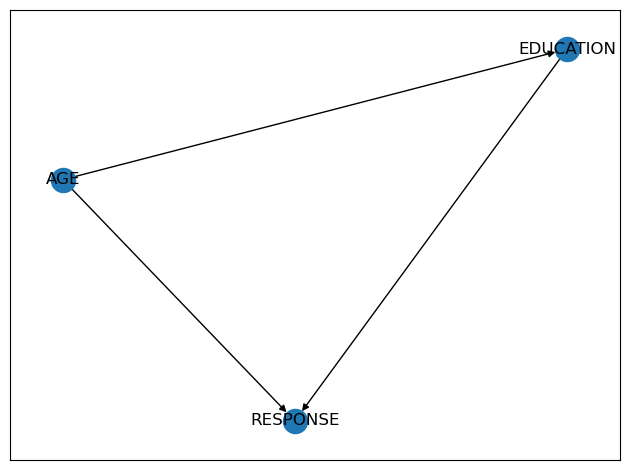

In [92]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("EDUCATION", "RESPONSE"),  ("AGE", "RESPONSE"), ("AGE", "EDUCATION") ])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()

The DAG has three variables, Education, Response, and Age. Education represents the highest level of education a participant has, response indicates their decision for the problem, and age represents the participant's age. Response is impacted by the education level and age of an individual, this is their decision made by what they know and their life experiences. The age of an individual impacts their education, as you can attain a higher education typically as age increases. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**State** which statistical model (or models) and their adjustment set(s) you need to evaluate the causal influence of education on responses and **explain your choice**.  **Limit your response to no more than 4 sentences.**

Statistical models that can evaluate the causal influence would be the logistical regression. In this model, you can include your confounding variables, age, so it is accounted for in the influence. The adjustment set would be {AGE} since it would remove a causal influence as age impacts both education and response. Therefore, it should be removed to remove a backdoor path. 

**Approximate the posterior distribution(s) for the parameters of the model(s)** using the trolley data. **Include the treatment combinations (Action, Intention, Contact) in your model(s) as a competing causes** as demonstrated in lecture.  

Note: *Sampling the posterior for this model and dataset using Hamiltonian Monte Carlo MCMC uses more memory than other models we have seen in this course. This is one of the drawbacks of this technique: its inability to scale efficiently to the size of the input data. Therefore, you should only **use a random subset of the data** when sampling from the posterior. The code below samples only about 70% of the observed data. Feel free to use the code exactly as written below:*  

```
import pandas as pd
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";").sample(n=7000)
```

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



In [ ]:
import pandas as pd
import pytensor.tensor as pt
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";").sample(n=2500) #7000 samples
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
age = standardize(trolley_df.age.values)
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
E = trolley_df.edu_new.cat.codes.values
with pm.Model() as trolley_model:
    alpha = pm.Normal("alpha", 0.0, 1, shape=6, testval=np.arange(6))

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)
    bAge = pm.Normal("bAge", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.extra_ops.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I + bAge * age

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints = alpha, observed=R)

    idata_trolley_model = pm.sample(2000, tune=2000, random_seed=42) #2000
    az.plot_posterior(
        idata_trolley_model,
        var_names=["bE", "bA", "bC", "bI", "bAge"],
        hdi_prob=0.89,
        ref_val=0,
        figsize=(15, 5)
    )
    plt.suptitle("Posterior Distributions of Model Parameters", fontsize=14)
    plt.show()

/tmp/ipykernel_341/2335845354.py:25: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal("alpha", 0.0, 1, shape=6, testval=np.arange(6))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, bA, bC, bI, bE, bAge, delta]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Now, answer the following questions:

* What do you conclude about the causal relationship between education and response? 
* What do you conclude about the causal relationship between age and response? 

Be sure to support your conclusions **with distribution plots** of your model's parameter estimates. **There is no need to perform a posterior predictive simulation.**
    
**Limit your response to no more than 8 sentences.**

The mean for coefficient bE is ~-0.2 meaning the association between education and response is evident but weak. The mean for coefficient bA is ~ -0.7 which is significantly larger in absolute value, suggesting a negative and stronger relation between age and response.

In [ ]:
grader.check("q3.3")

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before attempting to export your work for submission follow this process: First, make sure you have run all cells in your notebook **in order**. Then, **save your notebook**. Finally, run the export cell below. This sequence of actions will ensure that all code/output/plots appear in the generated PDF. **Only the PDF** will be evaluated for grading purposes.  When executed, the cell below will generate a zip file for you to submit.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)